In [ ]:
# MIT License
#
#@title Copyright (c) 2023 CCAI Community Authors { display-mode: "form" }
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# NLP Models for Climate Policy Analysis Part 2: Prompts for Sustainable Development Goals


Author(s):
*   Daniel Spokoyny, Carnegie Mellon University, dspokoyn@cs.cmu.edu


# Table of Contents

*   [Target Audience](#target-audience)
*   [Overview](#overview)
*   [Contributions](#contributions)
*   [Software Requirements](#software-requirements)
*   [Data Source](#data-source)
*   [Simple Prompt](#simple-prompt)
*   [In-Context Learning Prompts](#icl-prompt)

<a name="target-audience"></a>
# Target Audience

* Climate scientists seeking to use large language models to tackle a domain-specific problem in climate change.
* Data scientists with prior background in deep learning who are interested in building prompt-based large language model classifiers for climate texts.

<a name="Motivation"></a>
# Motivation

The Paris Agreement is an international treaty on climate change that was adopted in 2015.
One of the results of the treaty is that all participating countries are required to submit a Nationally Determined Contribution (NDC) report every five years.
These reports include a variety of vital information, such as the country's current greenhouse gas emissions, their goals for reducing emissions, and the policies they plan to implement to achieve these goals.
Since these reports are written in plain text and can be hundreds of pages long, many questions are difficult to answer automatically, such as:
*   What are the most common policies that countries are implementing to reduce emissions?
*   Which countries are on track to meet their goals?
*   Which countries are falling behind?
*   What are the most common barriers to reducing emissions?

One way to better understand these reports would be to use a common framework to help organize the information.
The Sustainable Development Goals (SDG) framework aims to provide a set of 17 climate goals (e.g. "Affordable and Clean Energy") with even more subgoals (or targets) that can be used to organize the information in the NDC reports.

Climate Watch, is a project by the World Resources Institute that has manually aligned the unstructured texts of the Nationally Determined Contribution reports to the semi-structured Sustainable Development Goals (SDG) framework.\footnote{https://www.climatewatchdata.org/}
By doing so, Climate Watch allows for different stakeholders to more easily compare progress across countries and identify which areas need financing, education, policy changes or other resources.

In this tutorial, we will build a prompt-based classifier and use this dataset to evaluate the performance of the classifier.
Since, new documents are being updated, a tool that can automatically align NDC reports to the SDG framework would save a lot of time and effort.

<a name="overview"></a>
# Overview: OpenAI Classification Extraction with Prompt Based In-Context Learning

In this tutorial we will use the state of the art Large Language Models (LLMs) to classify climate policy documents.
For the data we will work with the Nationally Determined Contributions (NDCs) documents from the Paris Climate Agreement. As the model we will use OpenAI's 'text-davinci-003' and attempt to use carefully crafted prompts to classify sentences from our dataset.

While in the previous tutorial we were focused on training supervised NLP models for text classification, with the advent of LLMs a more recent paradigm, prompting, has emerged. Prompting allows for interfacing with a trained machine learning model using text as input and text as output.

The rest of the tutorial is organized as follows

(1) **Dataset**: We are going to load the dataset and get it ready for prompt classification. \
(2) **Prompting**: We are going to construct a simple prompt and use it to classify sentences. \
(3) **ICL**: We are going to add to the prompt in-context learning examples and also increase the context of the input text.


<a name="contributions"></a>
# Contributions

Through introductory presentations and colab notebooks, we aim to expose the participants to:

(a) **Dataset**: Outlining a dataset of national climate action plans with corresponding annotations to the Sustainable Development Goals framwork. \
(b) **Prompting**: Designing prompts with in-context learning to perform novel text classification tasks. \
(c) **LLMs** Using large language models (LLMs) via python web-based APIs. \

<a name="software-requirements"></a>
# Software Requirements
This notebook requires the following libraries:
*   datasets (pip)
*   openai (pip)

`datasets` is a library which we will use to download the data required.
`openai` is a library from which we can access large language models via a python API. To use the model, you will need to sign up for an OpenAI Account (http://platform.openai.com/signup) and get an API key pasted below.


In [ ]:
# We need to install the following packages to run the code in this notebook
%%capture
!pip install datasets
!pip install openai

UsageError: Line magic function `%%capture` not found.


In [ ]:
# Import libraries
import openai
import json
from huggingface_hub import hf_hub_download
from datasets import load_dataset

/home/dspokoyn/.cache/pypoetry/virtualenvs/tutorial-IHiCU4EY-py3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# This here is how we will load the SDG dataset from the HuggingFace Hub.
# It has already been preprocessed for you to use.
dataset = load_dataset("dspoka/sdg-single")

# Here we will transform the dataset into a pandas dataframe
df_full = dataset['full'].to_pandas()

print(f'The dataset has {df_full.shape[0]} rows and {df_full.shape[1]} columns')
print(f'The columns are: {df_full.columns.values}')

Found cached dataset parquet (/home/dspokoyn/.cache/huggingface/datasets/dspoka___parquet/dspoka--sdg-single-c49077ade9802265/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 195.13it/s]

The dataset has 14219 rows and 13 columns
The columns are: ['iso3' 'country' 'goal' 'target' 'text' 'status' 'sector' 'response'
 'infotype' 'start' 'end' 'filename' '__index_level_0__']


<a name="data-source"></a>
# Understanding the SDG Dataset
- The important columns for us to know are 'goal', 'target', and 'text'.
- The 'text' column is the raw text that was annotated in the NDC documents. We will feed this into our model and use it to predict the the label.
- The 'goal' column is the SDG goal. We will use this as our main label for prediction.
- Each SDG 'goal' also has sub-goals or 'target' as the name of the column.
- Currently if you take a look the goals they are ["1",...,"17"]. Goal "12" make have a target "12.2".
- What exactly does goal "12" stand for exactly? Well for this we need to take a look at the metadata.
- Below, is an image that shows the 2030 progerss for the SDG goals and targets.
![SDG Goals](https://unece.org/sites/default/files/styles/max_1300x1300/public/2021-03/Graphic%20EN%20_PR_SDG%20Report.png?itok=Mwuuj3c7)


In [ ]:
def unpack_and_explain_metadata(metadata):
    '''Args:
        metadata: dictionary containing the metadata for the dataset.
    Returns:
        goal_idx_2_description: dictionary mapping goal index to the text description of the goal.
        goal_idx_2_goal_number: dictionary mapping goal index to the goal number. The goal number is what is currently in the dataset frame.
        target_idx_2_description: dictionary mapping target index to the text description of the target.
        target_idx_2_goal_idx: dictionary that maps a target index to the goal index. There are multiple targets per goal.
        target_idx_2_target_number: dictionary that maps a target index to the target number. The target number is what is currently in the dataset frame.

    '''
    goal_idx_2_description = metadata['goal_idx_2_description']
    goal_idx_2_description = {int(k):v for k,v in goal_idx_2_description.items()}

    goal_idx_2_goal_number = metadata['goal_idx_2_goal_number']
    goal_idx_2_goal_number = {int(k):v for k,v in goal_idx_2_goal_number.items()}

    target_idx_2_description = metadata['target_idx_2_description']
    target_idx_2_description = {int(k):v for k,v in target_idx_2_description.items()}

    target_idx_2_goal_idx = metadata['target_idx_2_goal_idx']
    target_idx_2_goal_idx = {int(k):int(v) for k,v in target_idx_2_goal_idx.items()}

    target_idx_2_target_number = metadata['target_idx_2_target_number']
    target_idx_2_target_number = {int(k):v for k,v in target_idx_2_target_number.items()}

    return goal_idx_2_description, goal_idx_2_goal_number, target_idx_2_description, target_idx_2_goal_idx, target_idx_2_target_number


# We will also download the metadata for the dataset from the HuggingFace Hub.
filepath = hf_hub_download(repo_id="dspoka/sdg-single", filename="metadata.json", repo_type="dataset")
with open(filepath) as f:
    metadata = json.load(f)

# In this method we will unpack the dictionaries and explain what each of the metadata means
goal_idx_2_description, goal_idx_2_goal_number, target_idx_2_description, target_idx_2_goal_idx, target_idx_2_target_number = unpack_and_explain_metadata(metadata)

### So lets look at a row of our dataset df_full and see how to use the metadata to understand it.

In [ ]:
# first row
print(df_full.iloc[0])
# and here is the text of the first row:
print('Text', df_full.iloc[0]['text'])


iso3                                                               AFG
country                                                    Afghanistan
goal                                                                12
target                                                            12.2
text                 Reduce rural peoples’ dependence on fuel for c...
status                                                          future
sector                                               energy efficiency
response                                                    mitigation
infotype                                                needs_and_gaps
start                                                          28031.0
end                                                            28096.0
filename                                         AFG-first_ndc-EN.html
__index_level_0__                                                    0
Name: 0, dtype: object
Text Reduce rural peoples’ dependence on fuel for cook

### Looking at row
- We see that this piece of text is from the NDC of the country "Afghanistan" and from this particular file: AFG-first_ndc-EN.html
- We also see some other topic labels, such that this is about the "energy efficiency" sector, is a type of mitigation Climate Response, and that its current implementation status is "future".
- We also see that the Sustainable Development Goals (SDG) goal is "12" and target is "12.2".
- Note idx or the index is 0-indexed for both goal_idx and target_idx.


In [ ]:
goal_number = "12"
goal_idx = None
for k,v in goal_idx_2_goal_number.items():
    if v == "12":
        goal_idx = k
        break

print(f'There are {len(goal_idx_2_description)} goals in the dataset.')
print(f'The "{goal_number}" goal has this text description: {goal_idx_2_description[goal_idx]}')

There are 17 goals in the dataset.
The "12" goal has this text description:  Ensure sustainable consumption and production patterns


We can also find all targets or subgoals that belong to this goal in specific.

In [ ]:
# Find all target_ids that belong to goal 0
target_ids = []
for target_id, goal_id in target_idx_2_goal_idx.items():
    if goal_id == goal_idx:
        target_ids.append(target_id)

# And now lets print all the descriptions of the targets that belong to goal 0
for target_id in target_ids:
    print(f'Target {target_id} has the following description: {target_idx_2_description[target_id]}')

Target 0 has the following description: By 2030, achieve the sustainable management and efficient use of natural resources
Target 9 has the following description: By 2030, substantially reduce waste generation through prevention, reduction, recycling and reuse
Target 20 has the following description: Implement the 10-year framework of programmes on sustainable consumption and production, all countries taking action, with developed countries taking the lead, taking into account the development and capabilities of developing countries
Target 21 has the following description: By 2020, achieve the environmentally sound management of chemicals and all wastes throughout their life cycle, in accordance with agreed international frameworks, and significantly reduce their release to air, water and soil in order to minimize their adverse impacts on human health and the environment
Target 29 has the following description: By 2030, ensure that people everywhere have the relevant information and aw

<Axes: xlabel='goal'>

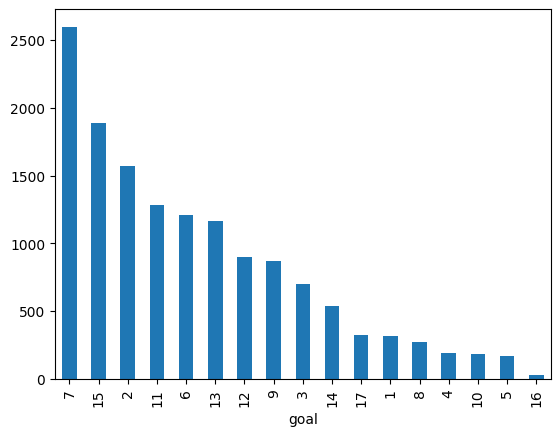

In [ ]:
# Lets also plot the histogram of goals in the dataset
df_full['goal'].value_counts().plot(kind='bar')
# ! Todo: also maybe add the contigency here to show that many possible predictions are possible?

<a name="simple-prompt"></a>
## Using prompting to classify the text into the correct SDG goal.
- In this section we will set up the classification task that we wish to perform.
- We will feed in the text from the NDC and have the model predict the corresponding SDG goal.
- Unlike in the previous tutorial where we fine-tuned a classifier on supervised data, here we will adopt the strategy of prompting a Large Language Model (LLM) to perform this in a zero-shot and few-shot manner.
- First let's do a quick review so that we can understand what prompting is and how it works.


## Large Language Models (LLMs) and Prompting
- In the previous tutorial, we fine-tuned a classification head on top of a pretrained transformer model.
- Given a sentence the model outputted a vector of dimension 'd' and we added new parameter weights (classification head) to map this vector to a vector of dimension 'k' where 'k' is the number of classes.
- Since these classifier's parameters are randomly initialized, we needed to train them on supervised data in order to learn the correct mapping.
- This may be limiting if we have too little labeled data or its too expensive to label data.
- What if instead of introducing new parameters we could use the same underlying transformer model to also perform the classification task?


## Enter Prompting
- LLMs are typically pretrained on large amounts of unlabeled text with a self-supervised objective: predicting the next word.
- The initial idea of prompting can then be thought as: "How can we change this classification task such that it falls naturally to next word prediction?"
- Suppose we start with a sentiment classification sentence like "I loved this movie, it was a blast!" where the true label is "positive".
- We can then add a prompt or a template of the form "{Movie Review}. This movie is {sentiment}"
    - input to model: "I loved this movie, it was a blast! This movie is"
    - and we can compare the next word prediction probability of the label "positive" versus "negative".
- Whichever is higher is the label we choose.
- This is a simple example of prompting, where we reframed sentiment classification to fit with the next word prediction which allows us to use the same pretrained model without any additional parameters.

### Current LLMs and Prompting
- The simple example above gives intuition for simple prompting but in practice current LLMs are much more flexible with the types of prompts that can be used.
- They have been trained on extra datasets for following instructions so that they can perform tasks where the answers don't have to be mapped directly to the next word prediction.
- In this first section, we are going to build a simple instruction prompt which will describe our SDG Goal classification task to the model.


In [ ]:
import os
import pandas as pd
import numpy as np
import random

# set seeds for reproducibility
np.random.seed(42)
random.seed(42)


# lets setup some global variables

# for goal prediction this will be the number of classes
N_PRED_CLASSES = len(goal_idx_2_goal_number)
# this will signify to the model the start of the input text
INPUT_MARKER = 'Input Text'

# This dictionary just contains the names of the columns to slightly longer names that are easier to understand.
column_names = {'goal': 'Sustainable Development Goal', 'target': 'Subgoal', 'status': 'Status', 'sector': 'Sector', 'response': 'Climate Response', 'infotype': 'Information Type'}
#

### Constructing the Prompt
- We are going to construct the prompt in two parts: instructions at the top and the input text to classify at the bottom.

In [ ]:
# for now we will skip the special_token as well as the what the "context" column is.
SPECIAL_TOKEN = "**"
def build_instruction(pred_column, obs_column):
    ''' Args:
            pred_column (str): the column that we are predicting
            obs_column (str): the column that we are observing (e.g. text, context)
        Returns:
            prompt (str): the prompt that will be used to query the model

    '''
    if obs_column == 'text':
        # describe what the model's input, task and class options are.
        prompt = f'Given the following {INPUT_MARKER} predict the {column_names[pred_column]} ({pred_column}) out of the following {N_PRED_CLASSES} options:\n'
    elif obs_column == 'context':
        prompt = f'Given the following {INPUT_MARKER}, marked with {SPECIAL_TOKEN} at the start and end. Predict the {column_names[pred_column]} ({pred_column}) out of the following {N_PRED_CLASSES} options:\n'

    # for now we will assume that we are predicting the goal column
    assert pred_column == 'goal'
    goal_number_2_goal_idx = {v: k for k, v in goal_idx_2_goal_number.items()}

    # Here we are building a dictionary that maps the goal number to the goal description
    goal_number_2_goal_description = {k:goal_idx_2_description[v] for k, v in goal_number_2_goal_idx.items()}

    # we sort this according to the goal number
    sorted_keys = sorted(int(k) for k in list(goal_number_2_goal_description.keys()))
    sorted_keys = [str(k) for k in sorted_keys]

    # build a list of strings where each string is the goal number and the goal description
    values = [f'{key}:{goal_number_2_goal_description[key]}' for key in sorted_keys]
    name = column_names[pred_column]
    # and we join each goal/description with a new line to the intruction
    prompt += name + '\n' +"\n".join(values) + "\n\n"
    return prompt
prompt_example = build_instruction(pred_column='goal', obs_column='text')
print(prompt_example)

Given the following Input Text predict the Sustainable Development Goal (goal) out of the following 17 options:
Sustainable Development Goal
1: End poverty in all its forms everywhere
2: End hunger, achieve food security and improved nutrition and promote sustainable agriculture
3: Ensure healthy lives and promote well-being for all at all ages
4: Ensure inclusive and equitable quality education and promote lifelong learning opportunities for all
5: Achieve gender equality and empower all women and girls
6: Ensure availability and sustainable management of water and sanitation for all
7: Ensure access to affordable, reliable, sustainable and modern energy for all
8: Promote sustained, inclusive and sustainable economic growth, full and productive employment and decent work for all
9: Build resilient infrastructure, promote inclusive and sustainable industrialization and foster innovation
10: Reduce inequality within and among countries
11: Make cities and human settlements inclusive, s

In [ ]:
def build_single_prompt(row, pred_column, obs_column, test_input_only=False):
    ''' Args:
        row (pd.Series): a row from the dataframe
        obs_column (str): the column that we are observing (e.g. text, context)
        test_input_only (bool):
            - if True, only return the input text
                - This is used for the test example.
            - if False, return the input text and the correct answer
                - This will be for in-context learning
        Returns:
            prompt (str): the second portion of the prompt
    '''
    prompt = f'\n{INPUT_MARKER}: {row[obs_column]}\n'
    if test_input_only:
        return prompt

    value = row[pred_column]
    prompt += f'{pred_column}:{value}\n'
    prompt += '\n'
    return prompt


# sample a random row from the dataframe to use as a test example
random_test_row = df_full.sample(1).iloc[0]
test_input = build_single_prompt(random_test_row, pred_column='goal', obs_column='text', test_input_only=True)

prompt_example += test_input
prompt_example += f'{"goal"}:'
# here we have the full instruction and prompt for the model
print(prompt_example)

Given the following Input Text predict the Sustainable Development Goal (goal) out of the following 17 options:
Sustainable Development Goal
1: End poverty in all its forms everywhere
2: End hunger, achieve food security and improved nutrition and promote sustainable agriculture
3: Ensure healthy lives and promote well-being for all at all ages
4: Ensure inclusive and equitable quality education and promote lifelong learning opportunities for all
5: Achieve gender equality and empower all women and girls
6: Ensure availability and sustainable management of water and sanitation for all
7: Ensure access to affordable, reliable, sustainable and modern energy for all
8: Promote sustained, inclusive and sustainable economic growth, full and productive employment and decent work for all
9: Build resilient infrastructure, promote inclusive and sustainable industrialization and foster innovation
10: Reduce inequality within and among countries
11: Make cities and human settlements inclusive, s

### Let's get model predictions for this test example now

In [ ]:
import os

# To use the model, you will need to sign up for an OpenAI Account (http://platform.openai.com/signup) and get an API key pasted below.
os.environ["OPENAI_API_KEY"] = "INSERT_YOUR_KEY_HERE"
openai.api_key = os.getenv("OPENAI_API_KEY")

# so we will use this particular model
MODEL_NAME = "text-davinci-003"

def get_model_response(test_prompt, pay=False):
  ''' test_prompt (str)
        - The full text prompt to send to the API for completion.
      pay (bool):
        - If False, return a dummy response. If True, send the prompt to the model API
        - This simple flag to let us test the function without calling the API which costs money.
      Returns:
        response (dict): the response from the API or a dummy response if Pay is False
  '''
  if not pay:
    # this is a dummy response that always returns the class 3
    response = {'choices':[{'text':'3'}]}
  else:
    response = openai.Completion.create(
      model=MODEL_NAME,
      prompt=test_prompt,
      temperature=0,
      max_tokens=4,
      top_p=1.0,
      frequency_penalty=0.0,
      presence_penalty=0.0
    )
  return response


# For now we can just test the function, but you can see what happens by setting pay=True
response = get_model_response(prompt_example, pay=False)
example_pred = response['choices'][0]['text']
print(example_pred)

1


In [ ]:
from sklearn.model_selection import train_test_split
def make_new_splits(df):
    '''We want to make sure that we split into train/val/test by documents and not by sentences. This helps us ensure that we aren't overfitting to a particular document/country.
    Suppose (hyperbolically) that each document only had one SDG class. Then if we split by sentence, the model may overfit by first predicting which country the sentence is from, and then predicting the SDG goal based on that country. This is undesirable and so it is better to split by documents.
    Args:
        df (pd.DataFrame): the full dataframe
    Returns:
        df_train (pd.DataFrame): the training dataframe
        df_val (pd.DataFrame): the validation dataframe
        df_test (pd.DataFrame): the test dataframe
    '''
    seed = 42
    filenames = df['filename'].unique()
    train_filenames, test_filenames = train_test_split(filenames, test_size=0.4, random_state=seed)
    val_filenames, test_filenames = train_test_split(test_filenames, test_size=0.5, random_state=seed)
    print(len(train_filenames), len(val_filenames), len(test_filenames))
    df_train = df[df['filename'].isin(train_filenames)]
    df_val = df[df['filename'].isin(val_filenames)]
    df_test = df[df['filename'].isin(test_filenames)]
    print(f'train: {df_train.shape}\tval: {df_val.shape}\ttest: {df_test.shape}')
    return df_train, df_val, df_test

df_train, df_val, df_test = make_new_splits(df_full)

128 43 43
train: (9611, 13)	val: (2507, 13)	test: (2101, 13)


<a name="icl-prompt"></a>
## In-Context Learning Prompts
- Before running and evaluating the model's performance, let's improve our prompt by adding in-context learning (ICL) examples.
- So after we describe the instructions for the task, we will now add a few input/output examples that we want the model to match.
- We will use a new function "in_context_prompt" which is simply a wrapper around the previous functions we used.

In [ ]:
def in_context_prompt(df, pred_column, obs_column, num_samples=3):
    '''
        Args:
            df (pd.DataFrame): the dataframe that we are sampling from
            pred_column (str): the column that we are predicting
            obs_column (str): the column that we are observing
            num_samples (int): the number of in-context learning samples to add to the prompt
        Returns:
            prompt (str): the full prompt for the model
    '''
    # as before we build the instruction
    prompt = build_instruction(pred_column, obs_column)

    # for each icl example we sample a random row from the dataframe
    for i in range(num_samples):
        row = df.sample(1)
        # note that we set test_input_only to false since we want to include the goal label for the icl examples
        prompt += build_single_prompt(row.iloc[0], pred_column, obs_column, test_input_only=False)
    return prompt


# We need to split df_full into train/val such that the ICL examples dont overlap with the test example
# df_train = df_full.sample(frac=0.8, random_state=42)
# df_val = df_full.drop(df_train.index)

icl_prompt_example = in_context_prompt(df_train, pred_column='goal', obs_column='text', num_samples=5)

# sample a random row from the dataframe to use as a test example
random_test_row = df_val.sample(1).iloc[0]
test_input = build_single_prompt(random_test_row, pred_column='goal', obs_column='text', test_input_only=True)

icl_prompt_example += test_input
icl_prompt_example += f'{"goal"}:'
print(icl_prompt_example)
print('-'*80)
print('True Goal', random_test_row['goal'])

Given the following Input Text predict the Sustainable Development Goal (goal) out of the following 17 options:
Sustainable Development Goal
1: End poverty in all its forms everywhere
2: End hunger, achieve food security and improved nutrition and promote sustainable agriculture
3: Ensure healthy lives and promote well-being for all at all ages
4: Ensure inclusive and equitable quality education and promote lifelong learning opportunities for all
5: Achieve gender equality and empower all women and girls
6: Ensure availability and sustainable management of water and sanitation for all
7: Ensure access to affordable, reliable, sustainable and modern energy for all
8: Promote sustained, inclusive and sustainable economic growth, full and productive employment and decent work for all
9: Build resilient infrastructure, promote inclusive and sustainable industrialization and foster innovation
10: Reduce inequality within and among countries
11: Make cities and human settlements inclusive, s

### That's it! We now have a prompt with the instruction, 5 in-context learning examples, and the input text to classify.
- For evaluation we will calculate the accuracy of the model on the test set.
- Since each sentence can have **multiple** SDG goals labeled, we will calculate whether the model can predict **any** of the correct labels.


In [ ]:
def calculate_accuracy(true_, pred_):
    ''' Calculate accuracy of predictions
        There could be multiple true labels for each example
        There is only one predicted label for each example
        Args:
            true_ (list): list of lists of true labels
            pred_ (list): list of predicted labels
        Returns:
            accuracy (float): the accuracy of the predictions
    '''
    assert len(true_) == len(pred_)
    # accuracy = sum([t==p for t, p in zip(true_, pred_)])/len(true_) # this is when there is only one true label
    right = 0
    for t, p in zip(true_, pred_):
        assert type(t) == list
        if p in t:
            right += 1
    return right/len(true_)

def most_common(lst):
    ''' helper function to select the most common element in a list
        Args:
            lst: list of elements
        Returns:
            most common element in the list
    '''
    # print('lst', lst)
    # print('type(lst)', type(lst)
    if type(lst) == str:
        return lst
    return max(set(lst), key=lst.count)

### Finally we are going to put this all together into a run_eval function
- This is the function that we will pass different arguments to in order to run different experiments.

In [ ]:
def run_eval(df_train, df_test, pred_column, obs_column, num_samples, num_icl, pay=False):
    '''
        Args:
            df_train (pd.DataFrame): the dataframe that we are sampling from for ICL examples
            df_test (pd.DataFrame): the dataframe that we are sampling from for test examples
            pred_column (str): the column name that we are predicting
            obs_column (str): the column name that we are observing
            num_samples (int): the number of test examples to evaluate on
            num_icl (int): the number of in-context learning examples to include in the prompt
            pay (bool): If False, return a dummy response. If True, send the prompt to the model API
        Returns:
        true_ (list): list of lists of true labels
        pred_ (list): list of predicted labels
        test_texts (list): list of the test examples
        test_prompt (str): the full last prompt used for the model for debugging/sanity check purposes
        test_ids (list): list of the ids of the test examples (this is useful such that the same test examples are not labeled multiple times)


    '''
    # Note if we set the test_prompt outside the for loop here
    # Then are using the same ICL prompt for all test examples.
    # If we do so, we can then more easily get batch predictions from the API
    # However, if we sample unlucky ICL examples, then the model may not perform as well.
    # So we will leave it inside the for loop for now.
    # test_prompt = in_context_prompt(df_train, pred_column, obs_column, num_icl)
    ################################################################################

    # Recall that one piece of text has many goals and targets.
    # So in our dataframe there multiple rows which have the same text.
    # This line to group makes sure that only unique texts are present.
    # It also aggregates the multiple goals for the same text into a list.
    df_group = df_test.groupby(obs_column, as_index=False).agg(lambda x: list(x))

    ######## Another strategy would be to use majority SDG goal
    # assert df_group[pred_column].apply(lambda x: type(x) == list).all()
    # df_group['majority'] = df_group[pred_column].apply(lambda x: most_common(x))
    ################################################################################


    # make sure that the text column is a list and only has one unique element
    if obs_column != 'text':
        assert df_group['text'].apply(lambda x: len(set(x)) == 1).all()
        df_group['text'] = df_group['text'].apply(lambda x: x[0])
        assert len(set(df_group['text'])) == 1

    # Sample num_samples test examples
    test_rows = df_group.sample(num_samples)

    # Get the test_ids
    test_ids = test_rows['__index_level_0__'].tolist()

    true_ = []
    pred_ = []
    test_texts = []
    # For each test example, get the model prediction
    for i in range(num_samples):
        test_row = test_rows.iloc[i]
        text = test_row['text']
        true = test_row[pred_column]
        assert type(true) == list

        test_prompt = in_context_prompt(df_train, pred_column, obs_column, num_icl)
        test_input = build_single_prompt(test_row, pred_column, obs_column, test_input_only=True)

        test_prompt += test_input
        test_prompt += f'{pred_column}:'

        test_texts.append(text)
        true_.append(true)

        response = get_model_response(test_prompt, pay)
        pred = response['choices'][0]['text'] #this is hardcoded for openai model
        pred_.append(pred)

    return true_, pred_, test_texts, test_prompt, test_ids

true_, pred_, test_texts, test_prompt, test_ids = run_eval(df_train, df_val, pred_column='goal', obs_column='text', num_samples=10, num_icl=5, pay=False)# switch pay to True to send the prompt to the OpenAI API

accuracy = calculate_accuracy(true_, pred_)
print('accuracy', accuracy)
print()

accuracy 0.0



### Checking Models Prediction
- Recall that since we are using prompting we are interpreting the model's textual output as a label.
- We are mapping the model's output of "3" to the label which corresponds to SDG Goal "3".
- But what if the model outputs a label outside of the range of our labels? or even fails to output a number but instead outputs a different word?
- We can check for these cases and see how often they occur.

In [ ]:
def check_predictions(pred_):
    ''' - Sanity check to make sure that all predictions are integers
        - and also are indexed in between the number of classes
        Args:
            pred_ (list): list of predicted labels
        Returns:
            None
    '''
    count_not_digit = 0
    count_in_range = 0
    for p in pred_:
        if not p.isdigit():
            count_not_digit += 1
        elif int(p) not in list(range(1, 1+N_PRED_CLASSES)):
            count_in_range += 1
        # assert p.isdigit()
        # assert int(p) in list(range(1, 1+N_PRED_CLASSES))
    print('count_not_digit', count_not_digit)
    print('count_in_range', count_in_range)

check_predictions(pred_)

count_not_digit 0
count_in_range 0


The large models from OpenAI have been tuned specifically to follow complex prompts or instructions. This is one reason why there should be only a few cases where the model fails to output a number or outputs a number outside of the range of our labels.

avg random acc: 0.0583


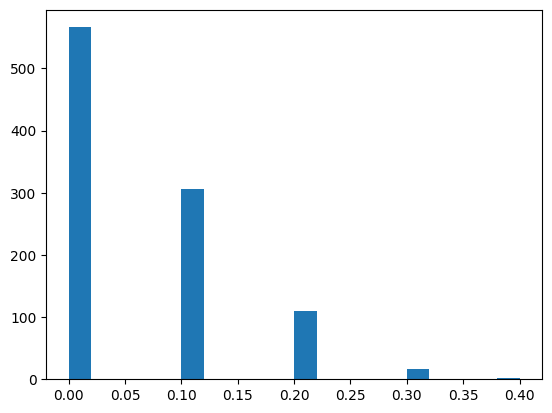

In [ ]:
def plot_random_histogram(true_):
    ''' Plot a histogram of accuracies of a random classifier
        Args:
            true_ (list): list of lists of true labels
        Returns:
            None
    '''
    num_trials = 1000
    random_accuracies = []
    for i in range(num_trials):
        random_pred = np.random.choice(list(range(1, 1+N_PRED_CLASSES)), size=len(true_))
        random_pred = [str(x) for x in random_pred]

        random_accuracy = calculate_accuracy(true_, random_pred)

        random_accuracies.append(random_accuracy)
    # histogram
    import matplotlib.pyplot as plt
    plt.hist(random_accuracies, bins=20)
    avg_acc = np.mean(random_accuracies)

    # this is how a random uniform classifier would perform
    print(f'avg random acc: {avg_acc}')

plot_random_histogram(true_)

### Using longer text contexts.
- We'll recall that the SDG text has annotations that are actually from the full text National climate action plan documents or NDCs.
- The dataset has already been preprocessed to align the text chunks that were annotated with their corresponding start and end indices in the full text documents.
- Here we will change the prompts to include longer "contexts" around the "texts" since this increased context could help the model make better predictions.
- Since this longer context may itself have different annotations with different SDG goals, we will also need to make the particular text we want to classify stand out.
- For this will change the instruction prompt, the ICL examples, as well as the the test input_text as well to use a special token to mark the text.
- To start lets load the full text documents and see how they look.

In [ ]:
def load_documents_from_hub():
    '''
        Load the full text of the documents from the huggingface hub.
        Returns:
            documents (list): list of dictionaries,
                each dictionary has the name of the file as the key and the full text as the value
    '''
    # Download from a dataset
    filepath = hf_hub_download(repo_id="dspoka/sdg-single", filename="ndc-all.json", repo_type="dataset")
    with open(filepath) as f:
        documents = json.load(f)
    return documents


documents = load_documents_from_hub()

In [ ]:
def span_check(span, doc):
    ''' Check that the span is valid with some basic assertions
        Args:
            span (tuple): tuple of (start, end) indices
            doc (str): document text
        Returns:
            None
    '''
    # check that all starts and ends are within the document
    start, end = span
    assert start < end
    assert start >= 0
    assert end <= len(doc)

def prepare_matched_df(df):
    ''' Prepare the dataframe to be used for matching.
        Args:
            df (pd.DataFrame): dataframe with the columns 'start' and 'end'
        Returns:
            df (pd.DataFrame): dataframe where the text was matched with start/end indices
    '''

    # 1. Lets subselect only data that has been matched by checking whether the start and end indices are present
    df = df[df['start'].notnull()]
    df = df[df['end'].notnull()]
    # 2. Lets also make sure start and end are integers not floats.
    df['start'] = df['start'].astype(int)
    df['end'] = df['end'].astype(int)
    return df

# drop rows that don't have start and end indices
df_train = prepare_matched_df(df_train)
df_val = prepare_matched_df(df_val)
df_test = prepare_matched_df(df_test)
print(f'Matched train: {df_train.shape}\tval: {df_val.shape}\ttest: {df_test.shape}')


Matched train: (8920, 13)	val: (2507, 13)	test: (2101, 13)


In [ ]:
def add_context(df, documents, window_size=200, special_token="**"):
    ''' For each sentence add a window of context before and after the sentence.
        Add a special token to denote the start and end of the sentence.
        Args:
            df (pd.DataFrame): dataframe with the columns 'filename', 'start', and 'end'
            documents (list): list of dictionaries,
            window_size (int): number of characters to include before and after the sentence
            special_token (str): special token to denote the start and end of the sentence
        Returns:
            df (pd.DataFrame): dataframe with the column 'context' added

    '''
    # add a new column to the dataframe called 'context'
    df['context'] = ''
    for i, row in df.iterrows():
        filename = row['filename']
        start = row['start']
        end = row['end']
        span = (start, end)

        doc = documents[filename]
        span_check(span, doc)

        start_context = max(0, start-window_size)
        end_context = min(len(doc), end+window_size)
        # print(f'start_context: {start_context}\tend_context: {end_context}')
        context = doc[start_context:start] + special_token + doc[start:end] + special_token + doc[end:end_context]
        df.at[i, 'context'] = context
    return df


WINDOW_SIZE = 200
df_train = add_context(df_train, documents, window_size=WINDOW_SIZE, special_token=SPECIAL_TOKEN)
df_val = add_context(df_val, documents, window_size=WINDOW_SIZE, special_token=SPECIAL_TOKEN)
print(df_train['context'].iloc[0])

d>Carbon sequestration on forest/rangelands, and forest carbon skills. Funding institutional capacity to monitor and verify projects. Better spatial planning for community and production agriculture. **Reduce rural peoples’ dependence on fuel for cooking and heating.**</td>
<td>100 Million/Year</td>
</tr>
<tr>
<td>Industry and Mining</td>
<td>Cleaner coal mining, leave-it-in-the-ground approaches, combustion, and transportation of minerals. Hydrocarbon fields manag


### We are ready to run evaluation again on the longer contexts
- before doing that we are going to include a few house keeping functions to save what we are evaluating and the results of the evaluation
- We will also use an eval_dict to keep track of the parameters of our evaluation experiments

In [ ]:
OUTPUT_DIR = 'outputs/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

def save_json(filename, data):
    with open(os.path.join(OUTPUT_DIR, filename), 'w') as f:
        json.dump(data, f)

def load_json(filename):
    with open(os.path.join(OUTPUT_DIR, filename), 'r') as f:
        data = json.load(f)
    return data

In [ ]:
# You can change the experiment here
# If you set pay to True this will use the API
# rough cost is 3-5 dollars for ~100 examples. (it depends on the length of the examples)
eval_dict = {'num_icl_examples': 5,
             'num_eval_samples': 10,
            # 'obs_column': 'context',
            'obs_column': 'text',
            'pred_column': 'goal',
            'model_name': MODEL_NAME,
            'window_size': WINDOW_SIZE,
            'special_token': SPECIAL_TOKEN,
            'input_marker': INPUT_MARKER,
            'pay': False}

# just for shorthand
e = eval_dict

In [ ]:
true_, pred_, test_text, test_prompt, test_ids = run_eval(df_train, df_val, e['pred_column'],
                                            e['obs_column'], e['num_eval_samples'],
                                            e['num_icl_examples'], e['pay'])

results = {'true': true_, 'pred': pred_, 'test_text': test_text, 'test_prompt': test_prompt, 'test_ids': test_ids}
filename = f"{e['obs_column']}_{e['pred_column']}_icl@{e['num_icl_examples']}"

# make sure to save the results
save_json(f'{filename}_results.json', results)
# load the results from file
results = load_json(f'{filename}_results.json')
# unpack the results
true_, pred_, test_text, test_prompt, test_ids = results['true'], results['pred'], results['test_text'], results['test_prompt'], results['test_ids']


print(f'In-Context Learning Prompt:\n {test_prompt}')
print('-'*80)

accuracy = calculate_accuracy(true_, pred_)
eval_dict['accuracy'] = accuracy
print('accuracy', accuracy)

print('-'*80)
# save the experiment ran with the accuracy
save_json(f'{filename}_eval_dict.json', eval_dict)

In-Context Learning Prompt:
 Given the following Input Text predict the Sustainable Development Goal (goal) out of the following 17 options:
Sustainable Development Goal
1: End poverty in all its forms everywhere
2: End hunger, achieve food security and improved nutrition and promote sustainable agriculture
3: Ensure healthy lives and promote well-being for all at all ages
4: Ensure inclusive and equitable quality education and promote lifelong learning opportunities for all
5: Achieve gender equality and empower all women and girls
6: Ensure availability and sustainable management of water and sanitation for all
7: Ensure access to affordable, reliable, sustainable and modern energy for all
8: Promote sustained, inclusive and sustainable economic growth, full and productive employment and decent work for all
9: Build resilient infrastructure, promote inclusive and sustainable industrialization and foster innovation
10: Reduce inequality within and among countries
11: Make cities and h